In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

figure_path = os.path.join(os.getcwd(), "report", "figure")
data_path = os.path.join(os.getcwd(), "data")

### Calibration of the single channel analyzer
we first plot the measurement of the Fe-57 spectrum that we performed for the calibration.
- We compare between the count and the LLD, which controls the lower limit in which the counts should be observed, i.e. the 

In [2]:
calib_data = np.genfromtxt(os.path.join(data_path, "calibration_moessbauer.csv"), delimiter=",", skip_header=1)
# LLD, count, time, ULD (Delta E = 100%)
lld_data, count_data = calib_data[:,0], calib_data[:,1]

# the time and uld value were the same for each measurement,
# so just take the value from first index
duration, uld_val = calib_data[0,2], calib_data[0,3]

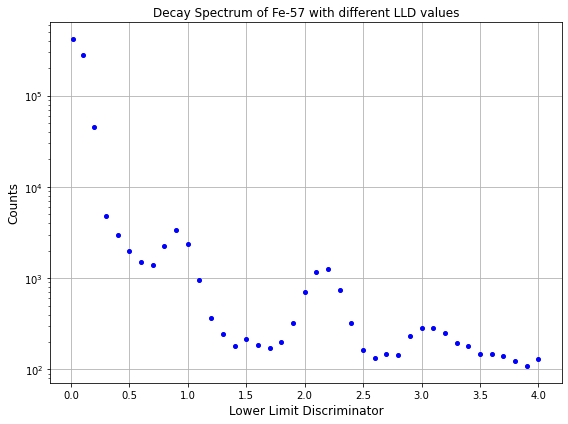

In [3]:
# plot the LLD vs count
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.semilogy(lld_data, count_data, marker="o", color="b", ls="", ms=4.0)
ax.set_xlabel("Lower Limit Discriminator", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Decay Spectrum of Fe-57 with different LLD values")
ax.grid()


# to say something about it, compare to the figure 4.14 in the textbook reference
# that way we can identify this as the 14.4 keV Moessbauer line
# not sure what else to do here, so moving on for now


### Looking at hyperfine structure of Moessbauer line (14.4keV transition)
- plot the results
- perform curve fit (from eq)

In [4]:
# get data for LR and RL respectively
moess_lr_data = np.genfromtxt(os.path.join(data_path, "velocity_LR_moessbauer.csv"), delimiter=",", skip_header=1)
moess_rl_data = np.genfromtxt(os.path.join(data_path, "velocity_RL_moessbauer.csv"), delimiter=",", skip_header=1)

# structure: velocity, motor speed (for reference), counts, time, number of turns
# the velocity is calculated from time and number of turns
# we plot count rate so we need velocity, counts and time

vel_lr_arr, counts_lr_arr = moess_lr_data[:,0], moess_lr_data[:,2]
vel_rl_arr, counts_rl_arr = moess_rl_data[:,0], moess_rl_data[:,2]

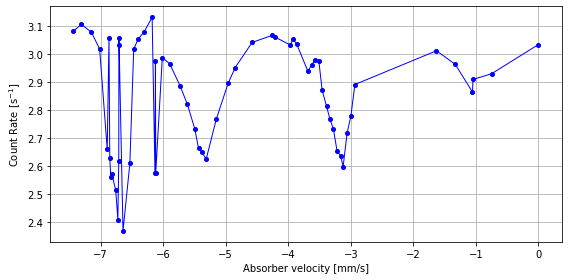

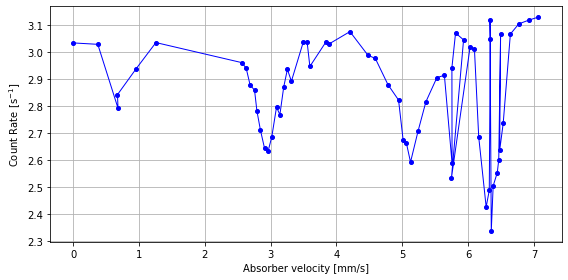

In [5]:
# plot our results (to check)
moess_raw_datas = [moess_lr_data, moess_rl_data]

for i, moess_raw_data in enumerate(moess_raw_datas):
    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.plot(moess_raw_data[:,0], moess_raw_data[:,2] / moess_raw_data[:,3], marker="o", ls="-", lw=1.0, ms=4.0, color="b")
    ax.set_xlabel("Absorber velocity [mm/s]")
    ax.set_ylabel("Count Rate [s$^{{-1}}]$")
    ax.grid()


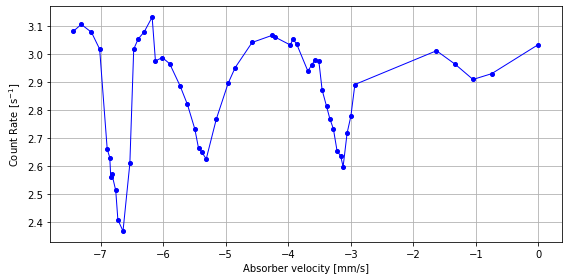

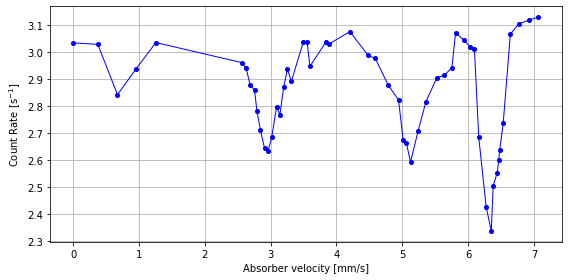

In [6]:
# remove the outliers
# looking at the numbers from apple, we have to remove:
# 7, 14, 15, 22, 24, 58, for lr
# 4, 39, 43, 49, 50, 55,  for rl
# all indices we count from 2 (contrary to python), so we need to shift index by 2

lr_outliers_idces = np.array([7, 13, 14, 15, 22, 24, 58]) - 2
rl_outliers_idces = np.array([4, 39, 43, 48, 49, 50, 55]) - 2

outliers_idces = [lr_outliers_idces, rl_outliers_idces]

moess_datas = []

for i, moess_raw_data in enumerate(moess_raw_datas):
    moess_data_filt = np.delete(moess_raw_data, outliers_idces[i], axis=0)
    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.plot(moess_data_filt[:,0], moess_data_filt[:,2] / moess_data_filt[:,3], marker="o", ls="-", lw=1.0, ms=4.0, color="b")
    ax.set_xlabel("Absorber velocity [mm/s]")
    ax.set_ylabel("Count Rate [s$^{{-1}}$]")
    ax.grid()

    # append filtered data for future use
    moess_datas.append(moess_data_filt)

/var/folders/lq/32167fz10179drz_rw4nmmy40000gn/T/ipykernel_97549/337018249.py:21: RuntimeWarning: divide by zero encountered in true_divide
  en = Gamma0 / (vel / c)


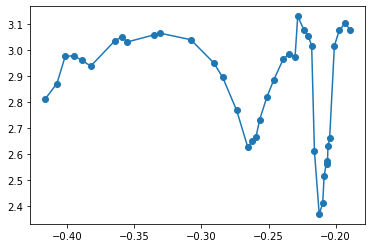

In [7]:
# perform fit
# to do this, we fit to a Lorentzian function 

# honestly kinda lost atm...

# define relevant constants here
# hbar = 1.05457182e-34 # J s
hbar = 6.58211957e-16  # eV s
c = 3e8  # m/s
Gamma0 = 4.7e-9  # in eV

def fit_func(E, I0, E0, Gamma):
    return I0  / (1 + (2 * (E - E0) / Gamma)**2.)

# convert velocity into photon transition energy

for i, moess_data in enumerate(moess_datas[:1]):
    vel = moess_data[:,0]
    count_rate = moess_data[:,2] / moess_data[:,3]

    en = Gamma0 / (vel / c)
    plt.plot(en[:40], count_rate[:40], marker="o")



In [ ]:
# found this code online for multi-lorentzian fit
# not sure how to fit for our data because still not used to
# the numpy notations you are using

from scipy.optimize import leastsq

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

xData, yData = np.loadtxt('HEMAT_1.dat', unpack=True )
yData = yData / max(yData)

generalWidth = 1

yDataLoc = yData
startValues = [ max( yData ) ]
counter = 0

while max( yDataLoc ) - min( yDataLoc ) > .1:
    counter += 1
    if counter > 20: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmin( yDataLoc )
    minY = yData[ minP ]
    x0 = xData[ minP ]
    startValues += [ x0, minY - max( yDataLoc ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ) )
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

print popt
testData = [ multi_lorentz(x, popt ) for x in xData ]

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( xData, yData )
ax.plot( xData, testData )
plt.show()
